## Imports and helpers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Read in data

In [3]:
df = pd.read_csv('./data/co2-mm-mlo_csv.csv', header=0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            727 non-null    object 
 1   Decimal Date    727 non-null    float64
 2   Average         727 non-null    float64
 3   Interpolated    727 non-null    float64
 4   Trend           727 non-null    float64
 5   Number of Days  727 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 34.2+ KB


- #### Monthly measurements of atmospheric CO2 from March 1958 to September 2018.
- #### Data are reported as a dry air mole fraction defined as the number of molecules of carbon dioxide divided by the number of all molecules in air, including CO2 itself, after water vapor has been removed. The mole fraction is expressed as parts per million (ppm). Example: 0.000400 is expressed as 400 ppm.
- #### Sourced from the US Government’s Earth System Research Laboratory, Global Monitoring Division. 
    - ##### Mauna Loa collection site (has the longest continuous series since 1958).

In [5]:
df.head()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,3/1/1958,1958.208,315.71,315.71,314.62,-1
1,4/1/1958,1958.292,317.45,317.45,315.29,-1
2,5/1/1958,1958.375,317.50,317.50,314.71,-1
3,6/1/1958,1958.458,-99.99,317.10,314.85,-1
4,7/1/1958,1958.542,315.86,315.86,314.98,-1


In [6]:
df.tail()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
722,5/1/2018,2018.375,411.24,411.24,407.91,24
723,6/1/2018,2018.458,410.79,410.79,408.49,29
724,7/1/2018,2018.542,408.71,408.71,408.32,27
725,8/1/2018,2018.625,406.99,406.99,408.90,30
726,9/1/2018,2018.708,405.51,405.51,409.02,29


In [7]:
# Change Date to be YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date'], yearfirst=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            727 non-null    datetime64[ns]
 1   Decimal Date    727 non-null    float64       
 2   Average         727 non-null    float64       
 3   Interpolated    727 non-null    float64       
 4   Trend           727 non-null    float64       
 5   Number of Days  727 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 34.2 KB


In [9]:
df.describe()

,Decimal Date,Average,Interpolated,Trend,Number of Days
count,727.000000,727.000000,727.000000,727.000000,727.000000
mean,1988.458333,349.555846,353.640702,353.633054,18.341128
std,17.500926,52.068588,27.443136,27.369003,12.242015
min,1958.208000,-99.990000,312.660000,314.620000,-1.000000
25%,1973.333500,328.425000,328.555000,329.295000,-1.000000
50%,1988.458000,351.310000,351.310000,351.370000,24.000000
75%,2003.583500,375.700000,375.700000,376.135000,28.000000
max,2018.708000,411.240000,411.240000,409.020000,31.000000


In [10]:
df.head()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03-01,1958.208,315.71,315.71,314.62,-1
1,1958-04-01,1958.292,317.45,317.45,315.29,-1
2,1958-05-01,1958.375,317.50,317.50,314.71,-1
3,1958-06-01,1958.458,-99.99,317.10,314.85,-1
4,1958-07-01,1958.542,315.86,315.86,314.98,-1


In [11]:
df.tail()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
722,2018-05-01,2018.375,411.24,411.24,407.91,24
723,2018-06-01,2018.458,410.79,410.79,408.49,29
724,2018-07-01,2018.542,408.71,408.71,408.32,27
725,2018-08-01,2018.625,406.99,406.99,408.90,30
726,2018-09-01,2018.708,405.51,405.51,409.02,29


In [12]:
# Set date to monthly periods
df['Date'] = df['Date'].dt.to_period('M')

In [13]:
df.head()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03,1958.208,315.71,315.71,314.62,-1
1,1958-04,1958.292,317.45,317.45,315.29,-1
2,1958-05,1958.375,317.50,317.50,314.71,-1
3,1958-06,1958.458,-99.99,317.10,314.85,-1
4,1958-07,1958.542,315.86,315.86,314.98,-1


In [14]:
# Inspect Average CO2 data
df['Average'].value_counts()

-99.99     7
 314.80    3
 355.73    3
 355.64    2
 321.39    2
 334.95    2
 316.79    2
 371.51    2
 332.41    2
 324.42    2
 322.25    2
 382.45    2
 320.44    2
 368.18    2
 327.34    2
 390.20    2
 322.39    2
 319.31    2
 351.31    2
 327.18    2
 391.86    2
 377.00    2
 376.70    2
 354.84    2
 365.59    1
 369.07    1
 364.40    1
 366.35    1
 365.52    1
 367.13    1
 378.28    1
 378.60    1
 369.68    1
 365.95    1
 370.99    1
 370.96    1
 370.30    1
 369.45    1
 366.90    1
 364.81    1
 364.02    1
 367.82    1
 366.64    1
 364.38    1
 364.31    1
 362.25    1
 360.29    1
 360.82    1
 362.49    1
 373.17    1
 365.26    1
 368.99    1
 374.38    1
 365.98    1
 367.24    1
 368.66    1
 369.42    1
 377.73    1
 365.37    1
 371.85    1
 374.01    1
 372.43    1
 373.85    1
 373.21    1
 372.25    1
 369.61    1
 368.45    1
 369.76    1
 371.24    1
 372.53    1
 373.20    1
 370.55    1
 374.12    1
 375.02    1
 375.76    1
 375.52    1
 370.75    1

In [15]:
# Replace -99.99 with np.nan for easier interpolation
df = df.replace(-99.99, np.nan)

In [16]:
# Interpolate missing data with mean of preceding and succeeding averages
df['Average'] = df['Average'].interpolate()

In [17]:
df.head()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03,1958.208,315.71,315.71,314.62,-1
1,1958-04,1958.292,317.45,317.45,315.29,-1
2,1958-05,1958.375,317.50,317.50,314.71,-1
3,1958-06,1958.458,316.68,317.10,314.85,-1
4,1958-07,1958.542,315.86,315.86,314.98,-1


In [18]:
# Set date as the dataframe index
df.set_index('Date', inplace=True)

In [19]:
# Make Average CO2 into dependent variable 'y'
y = df['Average']

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Average'>)

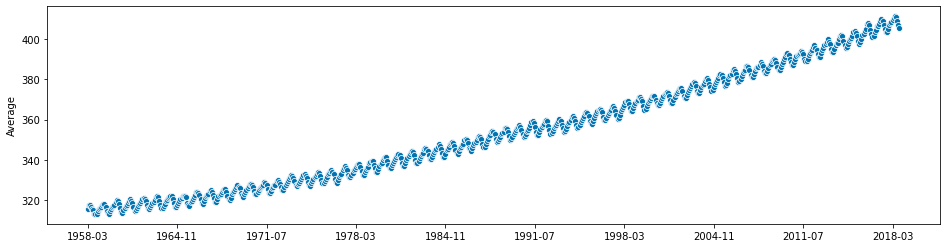

In [20]:
# Quick plot of y
plot_series(y)

In [21]:
# Forecast 5 years ahead of data to 2023 (One year ahead of now)
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2018-10", periods=60, freq="M")), is_relative=False
)
fh

ForecastingHorizon(['2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
             '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
             '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03',
             '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
             '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03',
             '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
             '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
             '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
             '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
             '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09'],
            dtype='period[M]', is_relative=False)

## Use Naive forecaster

In [22]:
forecaster = NaiveForecaster(strategy="last", sp=12)

In [23]:
forecaster.fit(y)

NaiveForecaster(sp=12)

In [24]:
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Average'>)

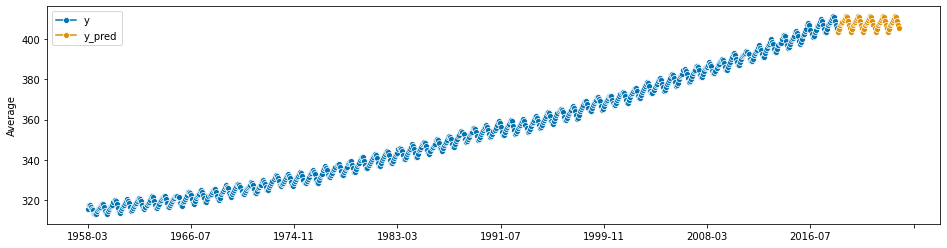

In [25]:
# Plot past data and NaiveForecaster predictions
plot_series(y, y_pred, labels=["y", "y_pred"])

- #### NaiveForecaster method plateaus based upon last training data and does not illustrate a sensible CO2 trend for prediction forecast.

## Use AutoARIMA forecaster

In [26]:
forecaster = AutoARIMA(sp=12)

In [27]:
forecaster.fit(y)

c:\Users\schel\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\schel\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\schel\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\schel\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\schel\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarni

AutoARIMA(sp=12)

In [29]:
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Average'>)

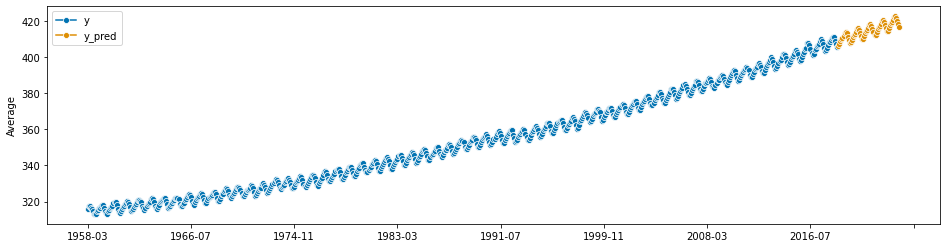

In [30]:
# Plot past data and ARIMA predictions
plot_series(y, y_pred, labels=["y", "y_pred"])

- #### AutoARIMA method illustrates sensible increasing CO2 trend for prediction forecast.
- #### Roughly 100 ppm more CO2 is in our current atmosphere from when data collection began in 1958.
    - ##### From approximately 320 to 420 ppm CO2

## Use AutoARIMA to extend the trend 20 years into the future

In [31]:
# Forecast 20 years ahead of data to 2038 (16 years ahead of now)
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2018-10", periods=240, freq="M")), is_relative=False
)
fh

ForecastingHorizon(['2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
             '2019-04', '2019-05', '2019-06', '2019-07',
             ...
             '2037-12', '2038-01', '2038-02', '2038-03', '2038-04', '2038-05',
             '2038-06', '2038-07', '2038-08', '2038-09'],
            dtype='period[M]', length=240, is_relative=False)

In [32]:
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Average'>)

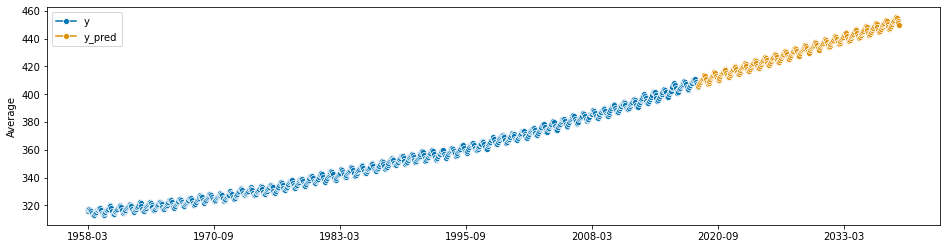

In [33]:
# Plot past data and ARIMA predictions
plot_series(y, y_pred, labels=["y", "y_pred"])

- # Roughly 140 ppm more CO2 could be in our atmosphere from when data collection began in 1958, if the trend continues.
    - ## From approximately 320 to 460 ppm CO2 in 2038.

## Use AutoARIMA to extend the trend 50 years into the future

In [34]:
# Forecast 50 years ahead of data to 2068 (66 years ahead of now)
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2018-10", periods=600, freq="M")), is_relative=False
)
fh

ForecastingHorizon(['2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
             '2019-04', '2019-05', '2019-06', '2019-07',
             ...
             '2067-12', '2068-01', '2068-02', '2068-03', '2068-04', '2068-05',
             '2068-06', '2068-07', '2068-08', '2068-09'],
            dtype='period[M]', length=600, is_relative=False)

In [35]:
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Average'>)

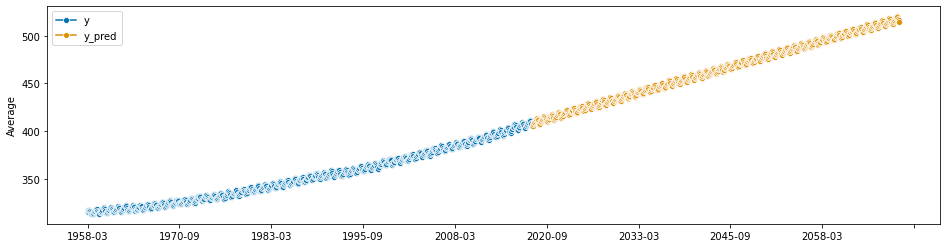

In [36]:
# Plot past data and ARIMA predictions
plot_series(y, y_pred, labels=["y", "y_pred"])

- # Roughly 200 ppm more CO2 could be in our atmosphere from when data collection began in 1958, if the trend continues.
    - ## From approximately 320 to 520 ppm CO2 in 2068.

# The need to switch to renewable and sustainable energy systems is now.  
# The longer we wait, the more we risk the future for our children and our children's children...